In [1]:
import os
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'

In [22]:
years = range(2006, 2023)
months = [f'{mo:02}' for mo in range(1,13)]
yrmo = [(yr, mo) for yr in years for mo in months]

In [4]:
# load cu2d
with open(os.path.join(base_path, f'align/cu2d.npz'), 'rb') as f:
    Cu2d = np.load(f)['Cu2d']
Cu2d.shape

(10200, 2)

In [5]:
with open(os.path.join(base_path, f'align/align_model_HDBSCAN.pkl'), 'rb') as f:
    hdbs = pickle.load(f)
np.amax(hdbs.labels_)

np.int64(1070)

In [6]:
C = [] 
Ck = 50 
for year, month in yrmo:
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        if Ck != cc.shape[0]: print(Ck, cc.shape[0])
        C.append(cc)
C = np.vstack(C)

In [7]:
T = []
for year, month in [(yr, mo) for yr in years for mo in months]:
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
        # TODO: hacky, maybe 'tfidf' shouldn't be a dict
        for k in range(len(tfidf['tfidf'].keys())):
            T.append(tfidf['tfidf'][k]['keywords'])

In [50]:
a, b = np.unique(hdbs.labels_, return_counts=True)
print(a)
print(b)

[  -1    0    1 ... 1068 1069 1070]
[3284    7   12 ...    9    7    8]


In [52]:
np.amax(b[1:])

np.int64(20)

In [8]:
cois = np.arange(np.amax(hdbs.labels_))

for coi in cois:
    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 6: 
        continue

    all_words = []
    for x in idx:
        all_words.extend(T[x][:10])
    
    # Count the frequency of each word
    word_counts = Counter(all_words)

    # Find the most common word
    common = word_counts.most_common(3)
    s_common = ' '.join([f'"{word}" ({count})' for word, count in common])

    print(f'{coi}: {s_common}')

0: "uh" (7) "raritywhy" (5) "ohcomeon" (4)
1: "clicked" (2) "link" (2) "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

/local/scr/stmorse/TMPDIR/ipykernel_3532754/2005271738.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


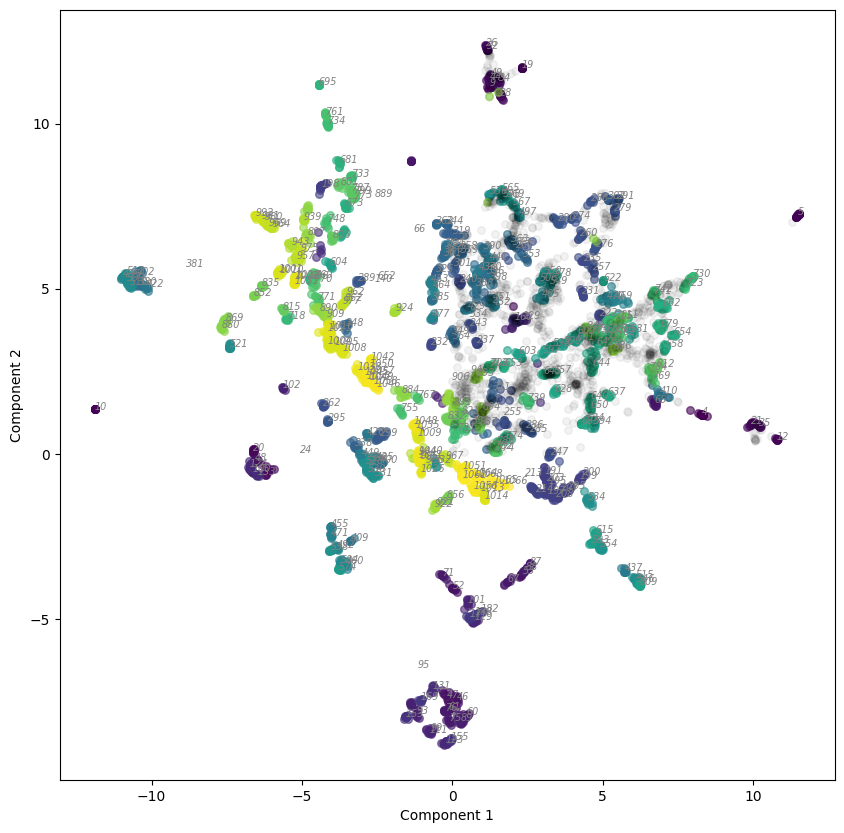

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(2, n_clusters):
    # NOTE: ignore coi=1 for viz (outlier)
    # if k == 1: continue

    idx = np.where(hdbs.labels_ == k)[0]

    if len(idx) < 8:
        continue

    # if np.any(Cu2d[idx,0] < 0) or np.any(Cu2d[idx,1] < 0):
    #     continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k, color='gray', fontsize='x-small', fontstyle='italic')

# plot uncategorized
idx = np.where(hdbs.labels_ == -1)[0]
uncat = Cu2d[idx,:]
uncat = uncat[(uncat[:,0] > 0) & (uncat[:,1] > 0)]
ax.scatter(uncat[:,0], uncat[:,1], s=30, c='k', alpha=0.05)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

# ax.set_xlim([0,25])
# ax.set_ylim([0,25])

plt.show()

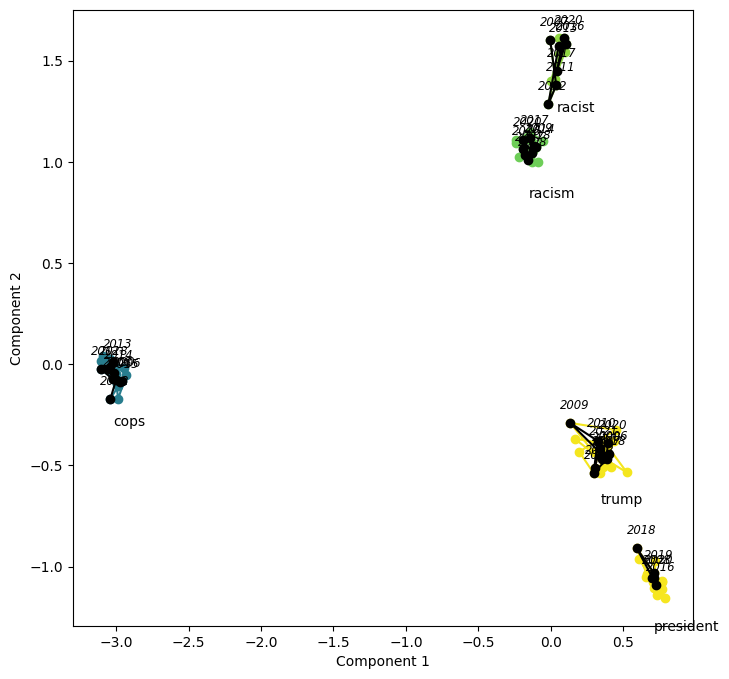

In [24]:
cois = [832, 891, 449, 1051, 1056]
hlabels = ['racism', 'racist', 'cops', 'trump', 'president']

fig, ax = plt.subplots(1,1, figsize=(8,8))

# use the same colors as full plot
n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

N = len(years)

for i, coi in enumerate(cois):
    idx = np.where(hdbs.labels_ == coi)[0]

    # ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[coi], alpha=0.6, label=k)
    ax.plot(Cu2d[idx,0], Cu2d[idx,1], color=colors[coi], linestyle='-', marker='o')

    # if coi in [832, 891, 774, 1051, 1056]:
    if coi in cois:
        annual_avgs = []
        # for y in [1, N // 2, N-1]:
        for y in range(N):
            # indices split marks
            # NOTE: assumes Ck=50 and 12 non-overlapping month-windows
            split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

            # get just indices in this year
            sub = idx[np.where((idx >= split_0) & (idx < split_1))[0]]

            # if empty, skip
            if len(sub) == 0:
                continue

            # get average position in this year
            avg = np.mean(Cu2d[sub,:], axis=0)
            ax.text(avg[0] - 0.07, avg[1] + 0.07, years[y], fontstyle='italic', fontsize='small')
            annual_avgs.append(avg)
        annual_avgs = np.vstack(annual_avgs)

        ax.plot(annual_avgs[:,0], annual_avgs[:,1], 'ko-')
        
    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1] - 0.25, hlabels[i])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

# ax.set_ylim([8,12])
# ax.set_xlim([11,15])

plt.show()

In [15]:
import pandas as pd

In [16]:
res = []

for coi in np.unique(hdbs.labels_):
    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 10:
        continue

    # Compute the step sizes (normed distances) between consecutive points
    x = C[idx, :]
    steps = x[1:,:] - x[:-1,:]
    stepsizes = np.linalg.norm(steps, axis=1)
    
    # Record the absolute total and average of these step sizes
    total_step_size = np.sum(stepsizes)
    average_step_size = np.mean(stepsizes)
    
    res.append([coi, len(idx), total_step_size, average_step_size])

res = pd.DataFrame(res, columns=['coi', 'size', 'total', 'average'])
res = res[res['coi'] != -1]
res.head()

,coi,size,total,average
1,1,12,1.423361,0.129396
2,4,19,2.801309,0.155628
3,5,20,0.694767,0.036567
4,9,11,2.295370,0.229537
5,19,11,1.403189,0.140319


In [17]:
res.sort_values(by='total', ascending=False).head(10)

,coi,size,total,average
170,1013,20,5.326198,0.280326
179,1051,20,4.211320,0.221648
144,856,18,4.169274,0.245251
184,1061,16,3.787150,0.252477
42,255,17,3.582881,0.223930
147,884,15,3.473516,0.248108
53,299,17,3.423245,0.213953
180,1053,19,3.421389,0.190077
64,388,19,3.403721,0.189096
78,469,18,3.391125,0.199478


In [46]:
# compute total displacement

res2 = []

for coi in np.unique(hdbs.labels_):
    if coi == -1:
        continue

    idx = np.where(hdbs.labels_ == coi)[0]
    
    if len(idx) < 10:
        continue

    # compute the distance between start and end point
    displacement = np.linalg.norm(C[idx[0],:] - C[idx[-1],:])

    # compute diameter
    diameter = np.max([np.linalg.norm(C[i] - C[j]) for i in idx for j in idx])
    
    res2.append([coi, len(idx), displacement, diameter])

res2 = pd.DataFrame(res2, columns=['coi', 'size', 'displacement', 'diameter'])
res2.head()

,coi,size,displacement,diameter
0,1,12,0.179645,0.261595
1,4,19,0.223856,0.400920
2,5,20,0.028796,0.091682
3,9,11,0.206001,0.381278
4,19,11,0.142035,0.258558


In [53]:
res2.sort_values(by='displacement', ascending=False).head(10)

,coi,size,displacement,diameter
57,352,10,0.387547,0.387547
68,422,10,0.380555,0.401815
115,673,11,0.358526,0.413935
77,469,18,0.352445,0.352445
183,1061,16,0.351543,0.393977
5,20,10,0.351169,0.351169
129,771,11,0.339144,0.339144
19,94,10,0.338243,0.389493
148,889,14,0.325789,0.350432
153,909,16,0.317354,0.354709


In [32]:
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 18]
n = len(labels_trim)
N = len(years)

# diffs holds the dist in year_i between group_j and group_k
# NOTE: upper triangular bc dist is symmetric
# (year, label, label)
diffs = np.nan * np.ones((N, n, n))
for y in range(N):
    # indices split marks
    # NOTE: assumes Ck=50 and 12 non-overlapping month-windows
    split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

    # loop cluster of row
    for xa in range(n):
        # get label number
        coi_a = labels_trim[xa]

        # all indices within C
        idx_a = np.where(hdbs.labels_==coi_a)[0]

        # get just indices in this year
        sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]

        # loop cluster of column
        for xb in range(xa, n):
            coi_b = labels_trim[xb]
            idx_b = np.where(hdbs.labels_==coi_b)[0]
            sub_b = idx_b[np.where((idx_b >= split_0) & (idx_b < split_1))[0]]

            # if either cluster is empty this year, skip
            if len(sub_a) == 0 or len(sub_b) == 0:
                diffs[y,xa,xb] = np.nan
                continue

            # compute average centroid
            avg_a = np.mean(C[sub_a], axis=0)
            avg_b = np.mean(C[sub_b], axis=0)

            # compute difference
            diff = np.linalg.norm(avg_a - avg_b)
            diffs[y,xa,xb] = diff

# compute change in distance from year_i to year_i+1
change = diffs[1:,:,:] - diffs[:-1,:,:]
print(change.shape)

(16, 24, 24)


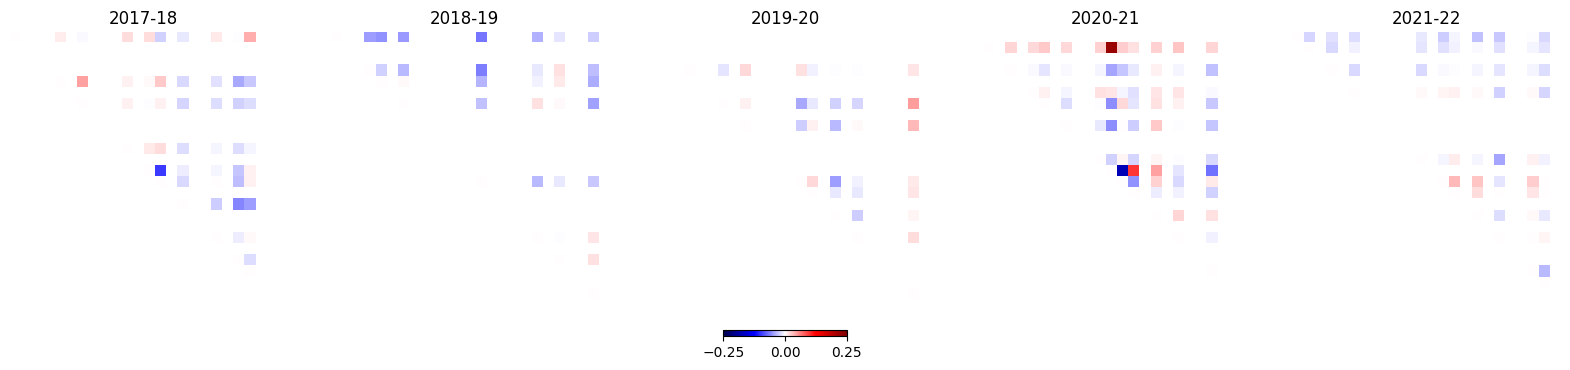

In [38]:
fig, axs = plt.subplots(1,5, figsize=(20, 4))

titles = [f'{years[y]}-{str(years[y+1])[-2:]}' for y in range(11, 16)]
for j, (ix, ax) in enumerate(zip(range(11, 16), axs.ravel())):
    cb = ax.imshow(change[ix,:,:], 
                 cmap='seismic', interpolation='none',
                 vmin=-0.25, vmax=0.25)
    
    ax.axis('off')
    ax.set_title(titles[j])

fig.colorbar(cb, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
# plt.tight_layout()
plt.show()

[Text(0, 0, 'som'),
 Text(0, 1, 'votes'),
 Text(0, 2, 'team'),
 Text(0, 3, 'season'),
 Text(0, 4, 'career'),
 Text(0, 5, 'him'),
 Text(0, 6, 'book'),
 Text(0, 7, 'car'),
 Text(0, 8, 'awesome'),
 Text(0, 9, 'tasty'),
 Text(0, 10, 'series'),
 Text(0, 11, 'um'),
 Text(0, 12, 'lmao'),
 Text(0, 13, '11'),
 Text(0, 14, 'moderators'),
 Text(0, 15, 'facebook'),
 Text(0, 16, 'religion'),
 Text(0, 17, 'games'),
 Text(0, 18, 'obama'),
 Text(0, 19, 'price'),
 Text(0, 20, 'republican'),
 Text(0, 21, 'economy'),
 Text(0, 22, 'president')]

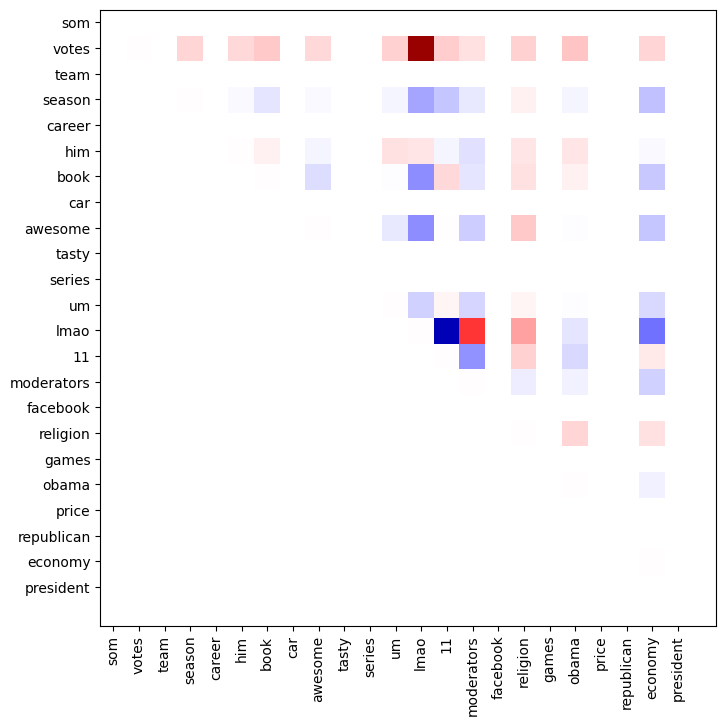

In [41]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.imshow(change[14,:,:], cmap='seismic', vmin=-0.25, vmax=0.25)

hlabels = ['som', 'votes', 'team', 'season', 'career', 'him', 'book', 'car', 'awesome', 'tasty', 'series', 'um', 'lmao', '11', 'moderators', 'facebook',
           'religion', 'games', 'obama', 'price', 'republican', 'economy', 'president']

ax.set_xticks(np.arange(len(hlabels)))
ax.set_yticks(np.arange(len(hlabels)))
ax.set_xticklabels(hlabels, rotation=90)
ax.set_yticklabels(hlabels)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
degree = 5
models = [make_pipeline(PolynomialFeatures(degree), LinearRegression()) for _ in range(2)]

ys_pred = np.zeros((N, 2))
for i in range(2):
    models[i].fit(ts_data, ys_data[:,i])
    ys_pred[:,i] = models[i].predict(ts_data)